# 1. Introduccion
A partir del dataset resultado del TP1 vamos a construir un modelo de regresión lineal que estime el precio de las propiedades.

## Integrantes:

- Juan Pablo Anselmo
- Francisco Portas
- Joaquin Pozo Cormick
- Claudio Pistoia
- Matias De Bernardis

## Objetivos y Tecnica:
- Seleccionar del dataset las propiedades solo de CABA y dentro de ellas los departamentos.
- Utilizaremos 3 modelos de Regresion Lineal:
   - Primer Modelo: Utilizar todas las variables (Salvo las que son redundantes) con LinearRegression
   - Segundo Modelo: Eliminar las variables segun su p-value y correlacion con target, con LinearRegression
   - Tercer Modelo: Utilizar todas las variables con Regularizacion (Lasso y ElasticNet)
- Analizar scores. En cada modelo estaran todos los scores pero nos basaremos en R2.

# 2. Importar librerias y dataset

## 2.1 Importar librerias

In [138]:
# Analisis de datos
import numpy as np 
import pandas as pd
pd.options.display.float_format = '{:.3f}'.format

# Graficos
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
import sklearn
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import LassoCV
from sklearn.linear_model import LinearRegression


## 2.2 Cargar dataset

In [139]:
data=pd.read_csv("properatti_clean.csv")
data.head()

,Unnamed: 0,property_type,place_name,state_name,lat,lon,price_aprox_usd,surface_total_in_m2,rooms,region_name,usd_m2,pileta,parrilla,cochera,gimnasio,baño
0,0,PH,Mataderos,Capital Federal,-34.662,-58.509,62000.000,55.000,Sin informacion,caba,1127.273,0,0,0,0,1
1,2,apartment,Mataderos,Capital Federal,-34.652,-58.523,72000.000,55.000,Sin informacion,caba,1309.091,0,0,0,0,1
2,4,apartment,Centro,Buenos Aires Costa Atlántica,-38.003,-57.549,64000.000,35.000,Sin informacion,gran_buenos_aires,1828.571,0,0,0,0,1
3,6,PH,Munro,Bs.As. G.B.A. Zona Norte,-34.533,-58.522,130000.000,106.000,Sin informacion,gran_buenos_aires,1226.415,0,0,0,0,1
4,7,apartment,Belgrano,Capital Federal,-34.560,-58.443,138000.000,45.000,Sin informacion,caba,3066.667,0,0,0,0,1


Dropeamos la primer columna ya que no nos aporta nada

In [140]:
data.drop(columns="Unnamed: 0", inplace=True)

# 3. Pre procesamiento de los datos

## 3.1 Filtramos los datos para CABA y Apartment

In [141]:
data_caba = data.loc[data.region_name == "caba"]
data_caba = data_caba.loc[data_caba.property_type == "apartment"]
data_caba = data_caba.reset_index(drop=True)
data_caba.place_name.value_counts()

Belgrano           2187
Palermo            1978
Caballito          1862
Recoleta           1215
Villa Urquiza      1205
                   ... 
Velez Sarsfield      10
Villa Soldati         8
Villa Real            8
Catalinas             1
Villa Riachuelo       1
Name: place_name, Length: 62, dtype: int64

## 3.2 Eliminar todas los filas que tengan Nans

In [142]:
data_caba.dropna(how="any", inplace=True)
data_caba.reset_index(inplace=True, drop=True)

## 3.3 Dropeamos las columnas irrelevantes

Eliminamos state_name y region_name porque es redundante que son de capital federal y de caba. Ademas eliminamos usd_m2 porque va a tener una multicolinealidad con price y m2 ya que es el resulado de su division.

In [143]:
data_caba.drop(columns=[ "state_name", "region_name", "usd_m2"], inplace=True)

## 3.4 Crear Dummies

In [144]:
# Creo funcion para dummies

from sklearn.preprocessing import OneHotEncoder 

def dummies_categoricas(categorias, dataframe):
    for feature in categorias:
        onehot = OneHotEncoder(drop = "first")
        X_enc= onehot.fit_transform(dataframe[[feature]]).toarray()
        enc_data = pd.DataFrame(X_enc, columns = onehot.get_feature_names_out())
        dataframe = pd.concat([dataframe.drop(columns=feature), enc_data], axis=1)
    return dataframe  

In [145]:
# Creo dummies

categorias = ["place_name", "rooms", "property_type"]

data_caba = dummies_categoricas(categorias,data_caba)

In [146]:
# Dataset final
data_caba

,lat,lon,price_aprox_usd,surface_total_in_m2,pileta,parrilla,cochera,gimnasio,baño,place_name_Agronomía,...,place_name_Villa Real,place_name_Villa Riachuelo,place_name_Villa Santa Rita,place_name_Villa Soldati,place_name_Villa Urquiza,place_name_Villa del Parque,rooms_2 ambientes,rooms_3 ambientes,rooms_4 o mas ambientes,rooms_Sin informacion
0,-34.652,-58.523,72000.000,55.000,0,0,0,0,1,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000
1,-34.560,-58.443,138000.000,45.000,0,0,0,0,1,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000
2,-34.560,-58.443,195000.000,65.000,0,0,0,0,1,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000
3,-34.581,-58.406,350000.000,104.000,0,0,0,0,1,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000
4,-34.591,-58.412,270500.000,118.000,0,0,0,0,0,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16871,-34.599,-58.403,165000.000,91.000,0,1,0,0,1,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000
16872,-34.587,-58.397,165000.000,44.000,0,1,0,0,1,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000
16873,-34.564,-58.443,410000.000,157.000,0,0,0,0,1,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000
16874,-34.564,-58.443,410000.000,157.000,0,0,0,0,1,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000


# 4. Machine Learning

## 4.1 Funciones

In [147]:
# Funcion para graficar Valores predichos vs Valores reales

def plot_predict(y_train_pred,y_test_pred,y_train, y_test, modelo=""):
    plt.figure(figsize=(10, 7))
    plt.scatter(y_train_pred, y_train, marker="v", s=20, c="red", alpha=0.8, label="Training data")
    plt.scatter(y_test_pred, y_test, marker="o", s=20, alpha=0.8, c="blue", label="Test data")
    plt.xlabel("Valores predichos")
    plt.ylabel("Valores reales")
    plt.title("Valores predichos vs Valores reales - " + modelo)
    plt.legend(loc="best")
    plt.plot([10.5, 13.5], [10.5, 13.5], c="black")

In [148]:
# Funcion para realizar OLS con statsmodels. Devuelve un dataframe con los columnas que tienen un p-value mayor a 95%

# OLS - Stats models
def ols_sumary(X_train, y_train, model):
    # Agregamos constante
    X_constant = sm.add_constant(X_train)

    
    # Fitiamos
    model_sm = sm.OLS(y_train,X_constant).fit()
    display(model_sm.summary())

    # Creamos diccionario para agregar los p-value
    d = {}
    for x in X_constant.columns.tolist():
        d[f'{x}'] = model_sm.pvalues[x]

    # Creamos dataframe y filtramos con las p-value mayores a 0.05
    df_pvalue= pd.DataFrame(d.items(), columns=['Var_name', 'p-Value']).sort_values(by = 'p-Value', ascending=False).reset_index(drop=True)
    print("-" *30)
    print("TABLA P-VALUE MAYOR A 0.05")
    print("-" *30)
    display (df_pvalue[df_pvalue["p-Value"] > 0.05])
    return (df_pvalue[df_pvalue["p-Value"] > 0.05])

In [149]:
# Funcion para realizar prediccion, realizar scores.

from sklearn import metrics

# Creo diccionarios para al final hacer un dataframe con el resumen de todos los scores

scores_mae = {}
scores_mse = {}
scores_rmse ={}
scores_r2 = {}
scores_r2_adjust = {}

# Creo funcion
def scores_regression(X_train, X_test, y_train, y_test, model, modelo=""):
    
    # Fit y prediccion del modelo seleccionado
    model_var = model.fit(X_train, y_train)
    y_train_pred = model_var.predict(X_train) 
    y_test_pred = model_var.predict(X_test)
    
#  MAE:
    
    mae_train = round(metrics.mean_absolute_error(y_train, y_train_pred), 3)
    mae_test= round(metrics.mean_absolute_error(y_test, y_test_pred),3)
    
    #scores_mae[(modelo + "_test")] = mae_test
    #scores_mae[(modelo + "_train")] = mae_train
          
            
    print ('MAE - TRAIN:', mae_train)
    print ('MAE - TEST:', mae_test)
    print("-"*20 + "\n")  
# MSE

    mse_train = round(metrics.mean_squared_error(y_train, y_train_pred), 3)
    mse_test= round(metrics.mean_squared_error(y_test, y_test_pred),3)
    
    #scores_mse[(modelo + "_test")] = mse_test
    #scores_mse[(modelo + "_train")] = mse_train
    
    print ('MSE - TRAIN:', mse_train )
    print ('MSE - TEST:', mse_test)
    print("-"*20 + "\n")

# RMSE:

    rmse_train = round(np.sqrt(metrics.mean_squared_error(y_train, y_train_pred)), 3)
    rmse_test= round(np.sqrt(metrics.mean_squared_error(y_test, y_test_pred)),3)
    
    #scores_rmse[(modelo + "_test")] = rmse_test
    #scores_rmse[(modelo + "_train")] = rmse_train
    
    print ('RMSE - TRAIN:', rmse_train)
    print ('RMSE - TEST:', rmse_test)
    print("-"*20 + "\n")

#R2

    r2_train = round((metrics.r2_score(y_train, y_train_pred)), 3)
    r2_test= round((metrics.r2_score(y_test, y_test_pred)),3)
    
    scores_r2[(modelo + "_test")] = r2_test
    #scores_r2[(modelo + "_train")] = r2_train
    
    print ('R2 - TRAIN:', r2_train)
    print ('R2 - TEST:', r2_test)
    print("-"*20 + "\n")

# R2 ajustado

    r2_adjust_train = round(1 - ( 1-r2_train ) * ( len(y) - 1 ) / ( len(y) - X.shape[1] - 1 ),3)
    r2_adjust_test = round(1 - ( 1-r2_test ) * ( len(y) - 1 ) / ( len(y) - X.shape[1] - 1 ),3)
    
    #scores_r2_adjust[(modelo + "_test")] = r2_adjust_test
    #scores_r2_adjust[(modelo + "_train")] = r2_adjust_train
    
    print ('R2 AJUSTADO - TRAIN:', r2_adjust_train)
    print ('R2 AJUSTADO - TEST:', r2_adjust_test)
    print("-"*20 + "\n")
    
# Plot grafico
    plot_predict(y_train_pred,y_test_pred,y_train, y_test, modelo)
 
# Imprimo mejor alpha en caso de utilizar regularizacion            
    if model_var != linreg:
        best_alpha = model_var.alpha_
        print(f"El mejor valor alpha es {best_alpha}")

#Imprimo intercepto y coeficientes   
    if model_var != linreg:
        print (f"El intercepto es {model_var.intercept_}")
        print("\t")
        print("Coeficientes del modelo:\t")
        print (model_var.coef_)
    

## 4.2 Cargo modelos

In [150]:
linreg = LinearRegression()
elastic = ElasticNetCV(cv=KFold(5, shuffle=True), alphas=[0.00001, 0.00005, 0.0001, 0.0005, 0.001, 0.005, 0.01,\
                                        0.05, 0.1, 1, 5, 10, 20, 30 ,40], random_state=1)
lasso = LassoCV(cv=KFold(5, shuffle=True), alphas=[0.00001, 0.00005, 0.0001, 0.0005, 0.001, 0.005, 0.01,\
                                        0.05, 0.1, 1, 5, 10, 20, 30 ,40], random_state=1)

## 4.3 Primer Modelo - Linear Regression sin eliminar variables

Utilizamos el dataset compeleto, sin eliminar ninguna variable (Salvo las previamente dropeadas)

In [151]:
# Creamos una variable para estudiarla mejor
data_caba_full = data_caba

### 4.3.1 Separo las features del target 

In [152]:
X = data_caba_full.drop(columns="price_aprox_usd")
y = data_caba_full["price_aprox_usd"]

### 4.3.2 Split

In [153]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

### 4.3.3 Estandarizar

In [154]:
scaler = StandardScaler()

X_train_scaler = scaler.fit_transform(X_train)
X_test_scaler = scaler.transform(X_test)

### 4.3.4 Modelo y scores
Realizamos el modelo con sklearn y luego analizamos el p-value de los coeficientes de las diferentes variables con StatsModels

MAE - TRAIN: 40477.997
MAE - TEST: 40743.322
--------------------

MSE - TRAIN: 5583496505.654
MSE - TEST: 5554569055.546
--------------------

RMSE - TRAIN: 74722.798
RMSE - TEST: 74528.981
--------------------

R2 - TRAIN: 0.815
R2 - TEST: 0.814
--------------------

R2 AJUSTADO - TRAIN: 0.814
R2 AJUSTADO - TEST: 0.813
--------------------



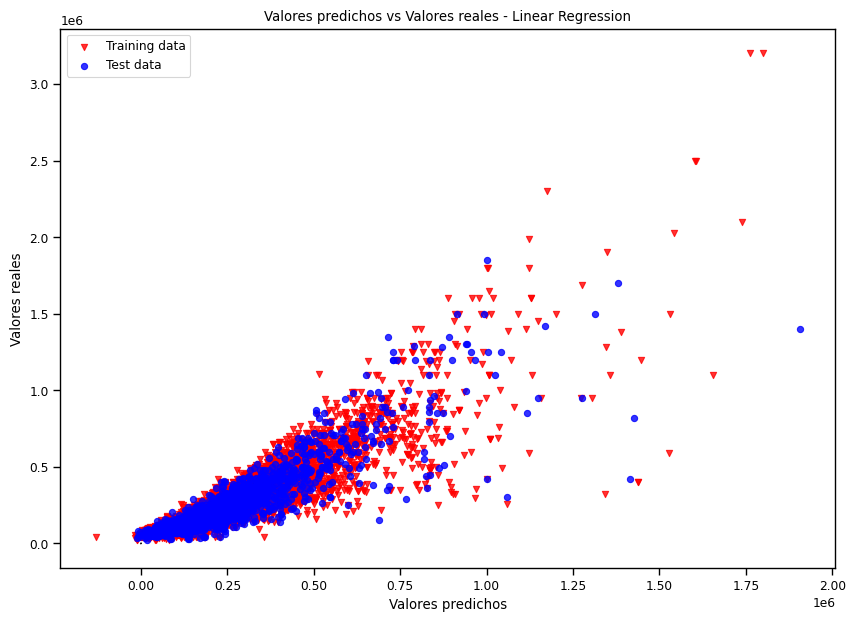

In [155]:
scores_regression(X_train_scaler, X_test_scaler, y_train, y_test, linreg, "Linear Regression")

### 4.3.5 Analizamos coeficientes con Stats Models

In [156]:
list_variables_p_value = ols_sumary(X_train, y_train, linreg)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        price_aprox_usd   R-squared:                       0.815
Model:                            OLS   Adj. R-squared:                  0.814
Method:                 Least Squares   F-statistic:                     812.9
Date:                Thu, 01 Dec 2022   Prob (F-statistic):               0.00
Time:                        23:07:15   Log-Likelihood:            -1.7065e+05
No. Observations:               13500   AIC:                         3.414e+05
Df Residuals:                   13426   BIC:                         3.420e+05
Df Model:                          73                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                            3.749e+06   9.01e+05      4.163      0.000    1.98e+06    5.51e+06
lat                             -1.058e+05   5.91e+04     -1.790      0.073   -2.22e+05       1e+04
lon                              1.273e+05   4.32e+04      2.948      0.003    4.27e+04    2.12e+05
surface_total_in_m2              2339.0866     14.169    165.086      0.000    2311.314    2366.860
pileta                           1.572e+04   2063.512      7.616      0.000    1.17e+04    1.98e+04
parrilla                        -6865.2746   1714.081     -4.005      0.000   -1.02e+04   -3505.435
cochera                          2.891e+04   1485.754     19.455      0.000     2.6e+04    3.18e+04
gimnasio                         2.662e+04   2463.825     10.806      0.000    2.18e+04    3.15e+04
baño                            -4794.1417   1400.208     -3.424      0.001   -7538.746   -2049.537
place_name_Agronomía              778.7203   1.94e+04      0.040      0.968   -3.73e+04    3.88e+04
place_name_Almagro               1763.1725   1.21e+04      0.146      0.884    -2.2e+04    2.55e+04
place_name_Balvanera            -2.148e+04   1.23e+04     -1.744      0.081   -4.56e+04    2660.948
place_name_Barracas             -3.312e+04   1.33e+04     -2.494      0.013   -5.91e+04   -7092.185
place_name_Barrio Norte          5.366e+04   1.21e+04      4.429      0.000    2.99e+04    7.74e+04
place_name_Belgrano              6.692e+04   1.26e+04      5.298      0.000    4.22e+04    9.17e+04
place_name_Boca                  -4.48e+04   1.54e+04     -2.907      0.004    -7.5e+04   -1.46e+04
place_name_Boedo                -1.089e+04   1.35e+04     -0.808      0.419   -3.73e+04    1.55e+04
place_name_Caballito             1.354e+04   1.19e+04      1.135      0.257   -9846.317    3.69e+04
place_name_Capital Federal       1.237e+04   1.34e+04      0.920      0.358    -1.4e+04    3.87e+04
place_name_Catalinas            -1.333e+05   7.59e+04     -1.757      0.079   -2.82e+05    1.55e+04
place_name_Centro / Microcentro -1.676e+04   1.36e+04     -1.233      0.218   -4.34e+04    9881.872
place_name_Chacarita             7309.1640    1.4e+04      0.521      0.602   -2.02e+04    3.48e+04
place_name_Coghlan                2.13e+04   1.42e+04      1.498      0.134   -6570.750    4.92e+04
place_name_Colegiales             2.53e+04   1.33e+04      1.908      0.056    -694.130    5.13e+04
place_name_Congreso             -3.027e+04   1.33e+04     -2.281      0.023   -5.63e+04   -4259.897
place_name_Constitución         -3.443e+04   1.37e+04     -2.518      0.012   -6.12e+04   -7627.432
place_name_Flores               -1.028e+04   1.21e+04     -0.849      0.396    -3.4e+04    1.34e+04
place_name_Floresta             -7796.4460    1.3e+04     -0.599      0.549   -3.33

------------------------------
TABLA P-VALUE MAYOR A 0.05
------------------------------


,Var_name,p-Value
0,place_name_Agronomía,0.968
1,place_name_Liniers,0.932
2,place_name_Almagro,0.884
3,place_name_Villa General Mitre,0.818
4,place_name_Villa del Parque,0.758
5,place_name_Parque Centenario,0.685
6,place_name_Villa Santa Rita,0.667
7,place_name_Villa Luro,0.659
8,place_name_Paternal,0.641
9,place_name_Chacarita,0.602


Observamos que hay 45 variables (Mas de la mitad) en donde sus coeficientes no son estadisiticamente significativos por lo cual vamos a eliminarlas ya lo mas probable es que no nos esten aportando en el modelo.

Se observa un R2 - Test : 0.814, es decir casi un 81% de rendimiento.

## 4.4 Segundo Modelo - Linear Regression filtrando variables

Eliminamos las variables que tengan un p-value mayor a 0.05 ya que no estan aportando al modelo y luego realizamos una matrix de correlacion de Pearson donde vamos a eliminar las variables sin correlacion con nuestro target (Nuestro limite va a ser 0 +/- 0.4)

### 4.4.1 Elimino las variables segun p-value

In [157]:
list_variables_p_value["Var_name"].values

array(['place_name_Agronomía', 'place_name_Liniers', 'place_name_Almagro',
       'place_name_Villa General Mitre', 'place_name_Villa del Parque',
       'place_name_Parque Centenario', 'place_name_Villa Santa Rita',
       'place_name_Villa Luro', 'place_name_Paternal',
       'place_name_Chacarita', 'place_name_Floresta',
       'place_name_Monte Castro', 'place_name_Villa Riachuelo',
       'place_name_Parque Chas', 'place_name_Tribunales',
       'place_name_Villa Pueyrredón', 'place_name_Boedo',
       'place_name_Velez Sarsfield', 'place_name_Flores',
       'place_name_Versalles', 'place_name_Parque Patricios',
       'place_name_Capital Federal', 'place_name_Parque Avellaneda',
       'place_name_Mataderos', 'place_name_Caballito',
       'rooms_Sin informacion', 'place_name_Parque Chacabuco',
       'place_name_Saavedra', 'place_name_Centro / Microcentro',
       'place_name_Once', 'rooms_3 ambientes', 'rooms_2 ambientes',
       'place_name_San Cristobal', 'place_name_Villa O

In [158]:
data_caba_clean = data_caba.drop(columns=list_variables_p_value["Var_name"].values)

### 4.4.2  Correlacion y eliminacion de variables

<AxesSubplot:>

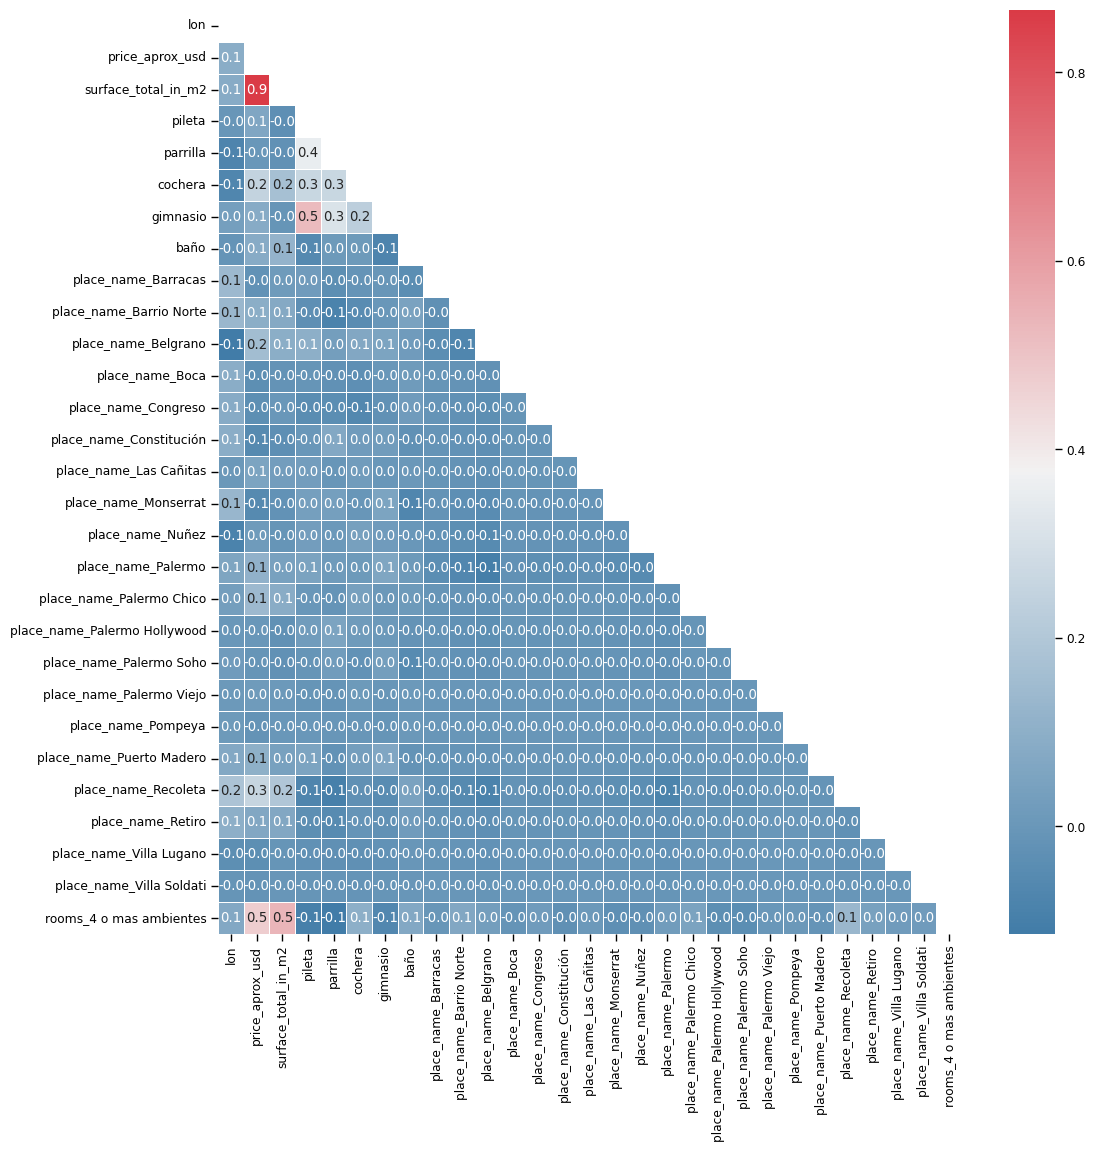

In [159]:
# Graficamos la correlacion de Pearson con un heatmap

fig,ax = plt.subplots(figsize=(12, 12))
cmap = sns.diverging_palette(240, 10, n=9, as_cmap=True)
matrix = np.triu(data_caba_clean.corr())
sns.heatmap(data_caba_clean.corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax, cmap=cmap, mask=matrix)

Rapidamente observamos que nuestra variable target tiene una correlacion significativa con muy pocas variables. Para filtrar las variables sin correlacion vamos a crear una funcion y eliminar las que tengan una correlacion entre 0 +/- 0.4 (Lo elegimos de forma arbitaria)

In [160]:
#Creamos funcion
def get_zero_corr(data):
    data_dummie = data    
    get_zero_corr = data_dummie.corr(method='pearson')
    #get_zero_corr = get_zero_corr.mask(np.tril(np.ones(get_zero_corr.shape)).astype(bool))
    get_zero_corr = get_zero_corr[(abs(get_zero_corr) >= 0) & (abs(get_zero_corr) <= 0.4)].stack().reset_index().sort_values(by=0, ascending=False)
    get_zero_corr.rename(columns={0: "pearson_coefficient"}, inplace=True)
    return get_zero_corr

In [161]:
# Busco las correlaciones que esten entre 0 +/- 0.4
zero_corr = get_zero_corr(data_caba_clean)
zero_corr.head(10)

,level_0,level_1,pearson_coefficient
110,parrilla,pileta,0.354
83,pileta,parrilla,0.354
112,parrilla,gimnasio,0.312
166,gimnasio,parrilla,0.312
139,cochera,parrilla,0.264
111,parrilla,cochera,0.264
138,cochera,pileta,0.261
84,pileta,cochera,0.261
667,place_name_Recoleta,price_aprox_usd,0.256
50,price_aprox_usd,place_name_Recoleta,0.256


In [162]:
# Filtro por nuestro target
mask_corr_price_0 = zero_corr["level_0"] == "price_aprox_usd"
zero_corr_var =  zero_corr.loc[(mask_corr_price_0)] 
zero_corr_var

,level_0,level_1,pearson_coefficient
50,price_aprox_usd,place_name_Recoleta,0.256
31,price_aprox_usd,cochera,0.247
36,price_aprox_usd,place_name_Belgrano,0.156
44,price_aprox_usd,place_name_Palermo Chico,0.142
43,price_aprox_usd,place_name_Palermo,0.109
49,price_aprox_usd,place_name_Puerto Madero,0.101
35,price_aprox_usd,place_name_Barrio Norte,0.095
28,price_aprox_usd,lon,0.092
33,price_aprox_usd,baño,0.084
32,price_aprox_usd,gimnasio,0.082


In [163]:
# Elimino estas variables
data_caba_clean.drop(columns=zero_corr_var.level_1.values, inplace=True)

In [164]:
# Nuevo dataset limpio
data_caba_clean

,price_aprox_usd,surface_total_in_m2,rooms_4 o mas ambientes
0,72000.000,55.000,0.000
1,138000.000,45.000,0.000
2,195000.000,65.000,0.000
3,350000.000,104.000,0.000
4,270500.000,118.000,1.000
...,...,...,...
16871,165000.000,91.000,0.000
16872,165000.000,44.000,0.000
16873,410000.000,157.000,0.000
16874,410000.000,157.000,0.000


Terminamos con 3 columnas (rooms_4 o mas ambientes, price_aprox_usd, surface_total_in_m2). Se eliminan todas las dummies de los barrios, y queda la variable "rooms_4 o mas ambientes". Ademas mantiene "surface_total_in_m2". Concluimos que para el modelo es mas importante la superficie antes que la localizacion.

Creamos el modelo

### 4.4.3 Split y Estandarizar

In [165]:
# Crear variables
X = data_caba_clean.drop(columns="price_aprox_usd")
y = data_caba_clean["price_aprox_usd"]

# Split
X_train_clean, X_test_clean, y_train_clean, y_test_clean = train_test_split(X, y, test_size=0.2, random_state=1)

# Scalar
scaler = StandardScaler()

X_train_scaler_clean = scaler.fit_transform(X_train)
X_test_scaler_clean = scaler.transform(X_test)


### 4.4.4 Modelo y scores

MAE - TRAIN: 40477.997
MAE - TEST: 40743.322
--------------------

MSE - TRAIN: 5583496505.654
MSE - TEST: 5554569055.546
--------------------

RMSE - TRAIN: 74722.798
RMSE - TEST: 74528.981
--------------------

R2 - TRAIN: 0.815
R2 - TEST: 0.814
--------------------

R2 AJUSTADO - TRAIN: 0.815
R2 AJUSTADO - TEST: 0.814
--------------------



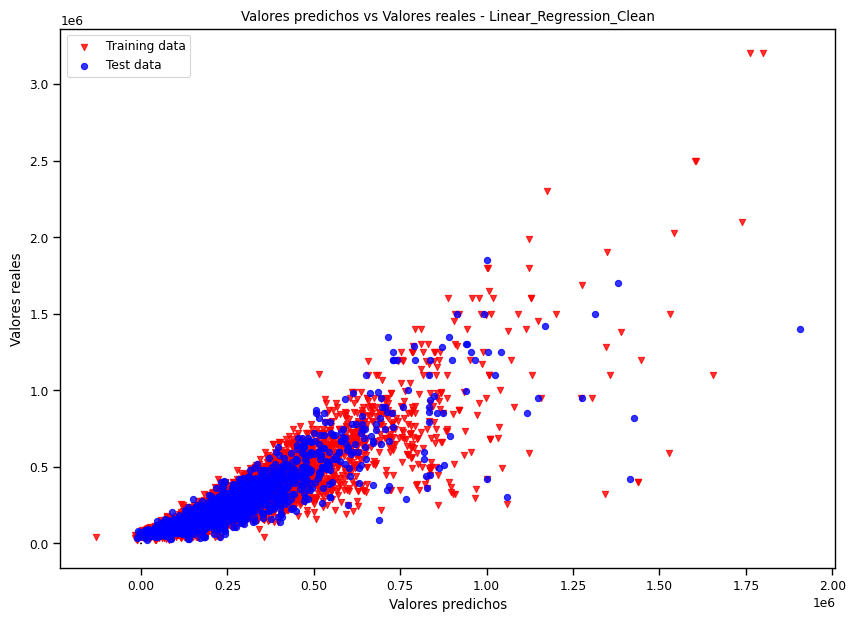

In [166]:
scores_regression(X_train_scaler_clean, X_test_scaler_clean, y_train_clean, y_test_clean, linreg, "Linear_Regression_Clean")

Utilizando solo 2 variables (surface_total_in_m y rooms_4 o mas ambientes ), llegamos aproximadamente al mismo rendimiento que al utilizar todas (0.814). No hay mejoria ni empeoramiento en el rendimiento del modelo. 

## 4.5 Tercer Modelo - Utilizamos todas las variables con Regularizacion (Lasso y ElasticNet)

### 4.5.1 Lasso

Realizamos un modelo con regulizacion con Lasso, con cross validation para encontrar el mejor alpha.

c:\Users\jpans\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 37676574848.765625, tolerance: 33072872313.187332
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\jpans\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 164544920879.65625, tolerance: 33072872313.187332
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\jpans\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 42034283431.421875, tolerance: 33072872313.187332
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\jpans\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:6

MAE - TRAIN: 40428.13
MAE - TEST: 40707.675
--------------------

MSE - TRAIN: 5584383297.332
MSE - TEST: 5559351462.213
--------------------

RMSE - TRAIN: 74728.731
RMSE - TEST: 74561.059
--------------------

R2 - TRAIN: 0.815
R2 - TEST: 0.813
--------------------

R2 AJUSTADO - TRAIN: 0.815
R2 AJUSTADO - TEST: 0.813
--------------------

El mejor valor alpha es 40.0
El intercepto es 191391.0987592593
	
Coeficientes del modelo:	
[-1.22676211e+03  4.24644303e+03  1.38515353e+05  6.06482189e+03
 -2.89792711e+03  1.39464346e+04  8.44814463e+03 -2.23901704e+03
 -3.22435429e+02 -5.50887114e+02 -4.21200032e+03 -4.01544111e+03
  1.01541305e+04  1.67602404e+04 -3.02537764e+03 -1.33094356e+03
  2.46390843e+03  7.01988105e+02 -1.13350118e+03 -1.80702496e+03
 -8.79939887e+00  1.03429762e+03  1.98962929e+03 -3.43468493e+03
 -3.45304125e+03 -3.45691767e+03 -1.66055131e+03  5.68428466e+03
 -6.99495676e+02 -1.48340427e+03 -4.80273900e+03 -8.92323933e+02
  5.42832354e+03 -1.77049254e+03  1.67429329

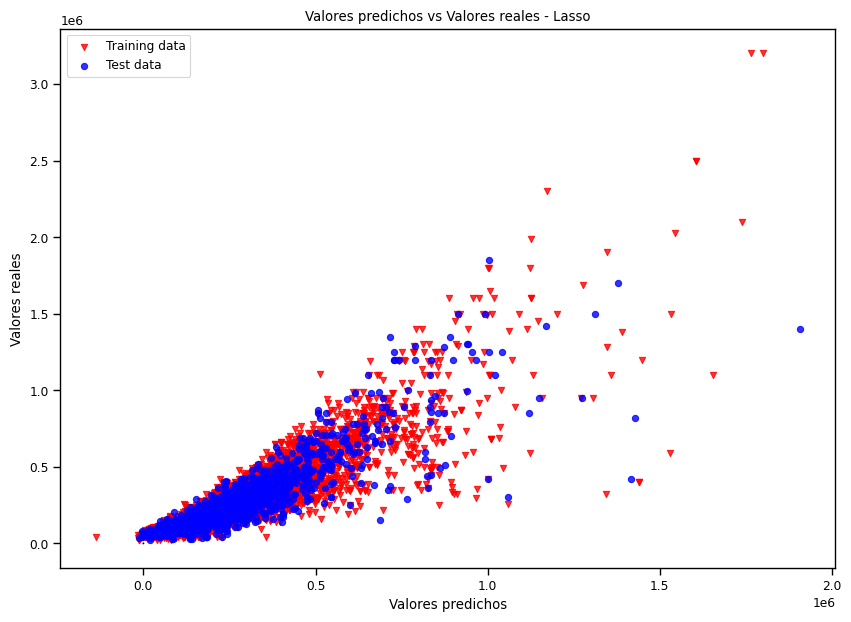

In [167]:
scores_regression(X_train_scaler, X_test_scaler, y_train, y_test, lasso, "Lasso")


Observamos que el mejor alpha es 40 y tiene un R2 del Test de 0.813, bastante bueno. Sin cambios respecto a los realizados sin regulacion.

### 4.5.2 ElasticNet

Con ElasticNet vamos a tener una regulizacion Lasso y Ridge. Utilizamos tambien cross validation para encontrar el mejor alpha

c:\Users\jpans\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 307013896811.9844, tolerance: 32180408576.770245
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\jpans\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27793294424039.99, tolerance: 32180408576.770245
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\jpans\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26963584817986.18, tolerance: 32180408576.770245
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\jpans\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634:

MAE - TRAIN: 40248.929
MAE - TEST: 40676.75
--------------------

MSE - TRAIN: 5647238476.206
MSE - TEST: 5549006193.73
--------------------

RMSE - TRAIN: 75148.11
RMSE - TEST: 74491.652
--------------------

R2 - TRAIN: 0.813
R2 - TEST: 0.814
--------------------

R2 AJUSTADO - TRAIN: 0.813
R2 AJUSTADO - TEST: 0.814
--------------------

El mejor valor alpha es 0.1
El intercepto es 191391.09875925942
	
Coeficientes del modelo:	
[ 2.08009611e+03  1.34338010e+03  1.28784100e+05  5.89297013e+03
 -2.13666466e+03  1.44717723e+04  8.18242007e+03 -1.53337258e+03
 -1.21438313e+03 -3.76956111e+03 -6.47962293e+03 -4.85553853e+03
  7.17598177e+03  1.10017537e+04 -3.69015094e+03 -2.67499384e+03
 -2.20559580e+03 -7.93340719e+02 -1.00511265e+03 -2.97080565e+03
 -1.76738065e+03 -1.20367051e+03 -3.36653065e+02 -4.69603568e+03
 -4.59969338e+03 -6.91242645e+03 -3.82613206e+03  4.28684197e+03
 -2.22563558e+03 -2.43755604e+03 -6.25124827e+03 -1.75427682e+03
  2.10109882e+03 -2.87704734e+03  1.16042908e+

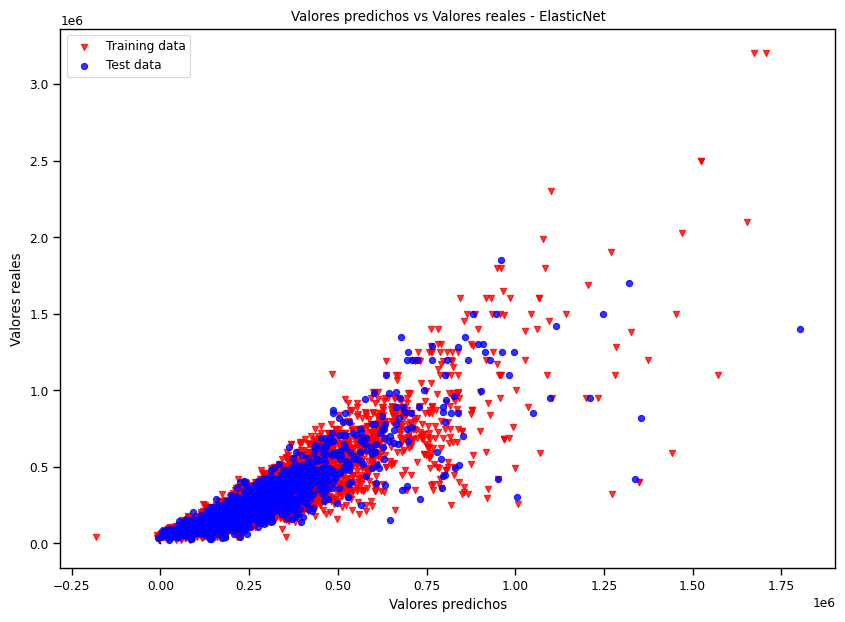

In [168]:
scores_regression(X_train_scaler, X_test_scaler, y_train, y_test, elastic, "ElasticNet")

El mejor alpha es 0.1. Observamos un rendimiento muy parecido a los anteriores

# 5. Scores

## 5.1 Tabla (R2)

In [169]:
score_regression = pd.DataFrame({"Modelos": scores_r2.keys(), "R2": scores_r2.values()}).sort_values(by="R2", ascending=False).reset_index(drop=True)

display(score_regression)

,Modelos,R2
0,Linear Regression_test,0.814
1,Linear_Regression_Clean_test,0.814
2,ElasticNet_test,0.814
3,Lasso_test,0.813


## 5.2 Grafico R2


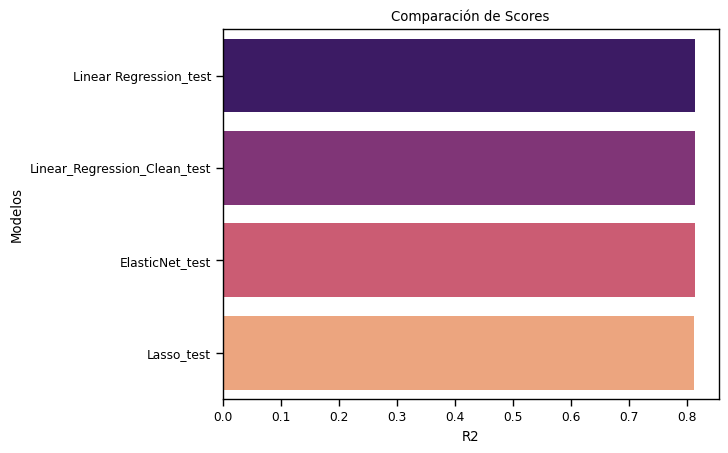

In [170]:
scores_columns= ["R2"]

for scores in scores_columns:
    sns.set_context('paper')
    ax = sns.barplot(x = score_regression[scores] ,y = 'Modelos',data = score_regression.sort_values(by=scores, ascending=False), palette = 'magma')
    ax.set(xlabel=scores, ylabel="Modelos", title="Comparación de Scores")
    plt.show()

# 6. Conclusion

Realizamos 3 modelos de Regresion Lineal:
- En el primero solo eliminamos las variables redundante y realizamos un modelo de Linear Regression sin regularizacion. Nos dio un rendimiento de Test R2 de 0.814. Utilizamos StatsModels para evaluar el p Value de sus coeficientes donde observamos que varias variables se encontraban en valores estadísticamente  no significativos. 

-  En el segundo modelo eliminamos las variables con p-values mayores a 0.05 y ademas analizamos la correlacion de Pearson. Se decidio dropear las variables sin correlacion con el target (Correlacion Pearson entre 0 +/- 0.4). Se realizo nuevamente un modelo con Linear Regression que resulto casi con el mismo rendimiento (Mejoro un 0.01, insignificante)

- En el tercer modelo realizamos regresion lineal con regularizacion (Lasso y ElasticNet) utilizando todas las variables. El rendimiento de ambas fue identica a las previas

En conclusión la eliminación de variables y el uso de regularización no produjo un efecto significativo en el rendimiento del modelo. Una diferencia fue que se pasó de necesitar 74 variables para llegar al mismo resultado a tan solo 2 (surface_total_in_m2 y rooms_4 o mas ambientes), lo que puede ayudar a evitar un overfitting del mismo.

Con los 3 modelos llegamos aproximadamente a un 81% de rendimiento según el score R2, lo que es un valor sumamente bueno. En el segundo modelo no se tomó en cuenta la localización y dio el mismo resultado que el anterior con todas las variables por lo cual habría que ver si en la preparación del dataset hubo algún error para que no se llegara a priorizar variables de localización o si el poder predictivo de la superficie es mayor que el resto.

Dentro de todo creemos que tuvimos un gran rendimiento con los modelos realizados.

